Recently I have been attempting to improve retrieval results of the NAA29k dataset, but results have been difficult to improve upon. Mostly, changing the image sizes in the retrieval pipeline (as is usually done) leads to worse results. To visualise this, the pipeline of common methods is repeated with differing image sizes (with either square images or maintaining aspect ratio) compared to the 'baseline', which is the original image size.

![sizes.png](sizes.png)

Note that NAA29k images are already square with dimensions 256x256. For Paris6k, Oxford5k, and Holidays, the original image size is 1024 on the greater side, so decreasing can improve performance. However, for NAA29k the option to maintain improvement is to keep the original size.

## Visual Grounding
Since many of the images in the NAA29k contain multiple images, pooling could be improved using visual grounding to ground the available text to the visual information. Object localisation cannot be done using bounding boxes as there is no such metadata in NAA29k.

A kind of unsupervised grounding was done in [Learning Unsupervised Visual Grounding Through Semantic Self-Supervision](https://arxiv.org/pdf/1803.06506.pdf) which trains a model using 'concepts' that appear in the text captions alongside the image. However, they use bounding boxes as targets for training. For example, when trained, different text locates different locations in an image:
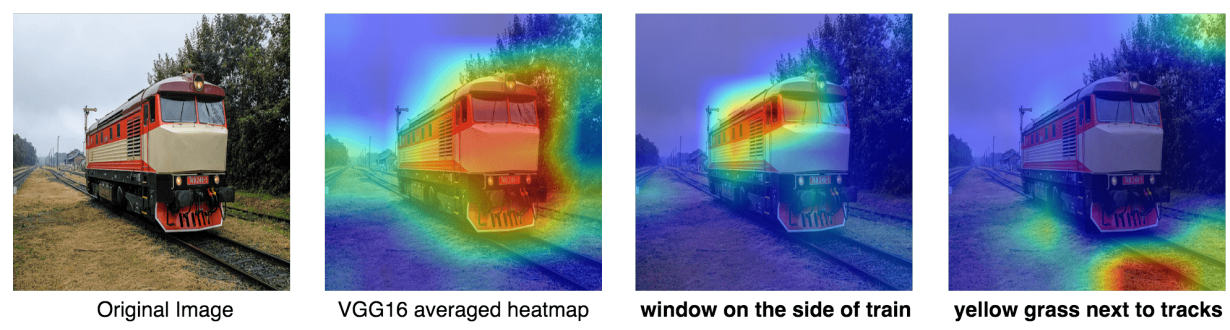

Using this method, I adapted an off-the-shelf POS (part-of-speech) tagger to extract concepts (*i.e.* nouns) from the NAA29k set like:
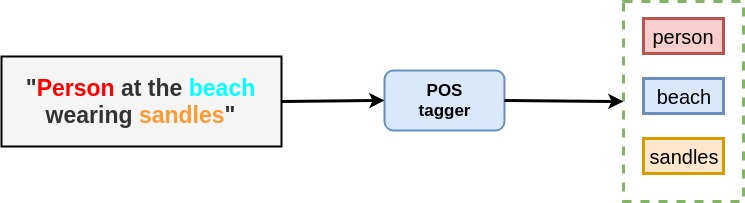
with the idea that common concepts are visually similar, even in different images. Then, by training a module to produce an attention map, embedded concepts can guide whether an image part requires attention with the given concept:
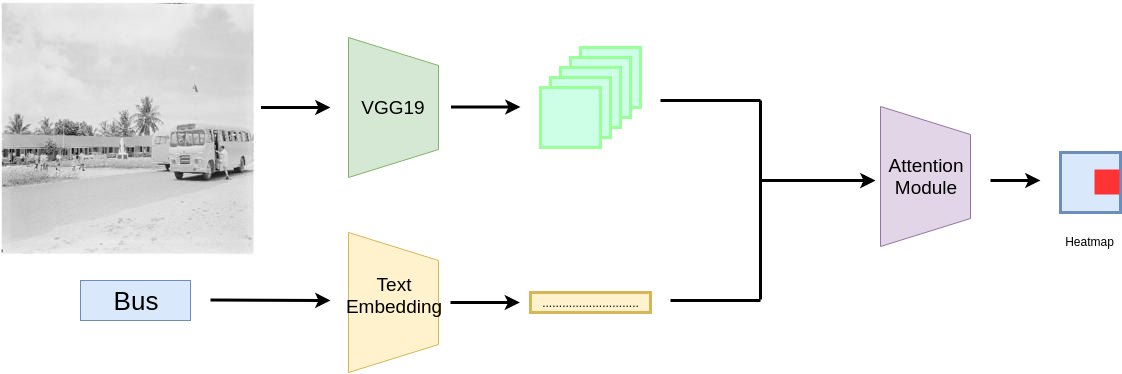

### Difficulty
Since there are no direct targets, I produce a triplet loss using the positive as the similarity of heatmap to the 'mean concept', and the negative as the similarity of heatmap to another mean concept found in the image. The idea is that it would prevent the model cheating and using the whole image as attention. However, current test are not working as desired even with a smaller toy dataset, and the loss function may be the problem.

## Global Diffusion

We also talked about using global diffusion on NAA29k using both the visual and text data. Here diffusion is performed on the three benchmark datasets, and on NAA29k by concatentating the RMAC features and text embeddings. However, performance does not improve upon sumpool.
is report goes over the implementation and the results of the global diffusion process on benchmark datasets and the NAA29k dataset.

### Results

The NAA29k_100 dataset was extracted with size 768. Oxford5k was whitened with Paris6k data, and Paris6k was whitened with Oxford5k data.

|Dataset   |MaxPool|SumPool|RMAC|RMAC+Global Diffusion|
|----------|-------|-------|----|---------------------|
|Oxford5k  |48.3|61.0|62.7|**66.9**|
|Paris6k   |58.6|66.8|75.1|**83.9**|
|Holidays  |73.2|84.3|**86.5**|84.9|
|NAA29k_100|27.1|**52.4**|41.2|43.4|

In all cases the diffusion process begins by peaking mAP early, dipping, then converging to the closed-form solution. Below is the diffusion process of the Paris6k dataset with Mean Average Precision calculated at each iteration, and the closed-form solution mAP value represented as the horizontal line:

![title](Paris6kIterations.png)

## Discussion
For each dataset except Holidays, diffusion improves upon the results. I believe the results decrease in Holidays because there are fewer 'manifolds'; Holidays is constructed using small but diverse groups (mostly about 4 images each), so there are no such complex 'manifolds'.
The nature of NAA29k is that the simpler sumpooling method provides a better result than R-MAC. Tweaking R-MAC with a smaller ***L*** parameter may improve it.
